In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Local imports
import utils as u

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy as cart
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

u.check_memory()

/home/lalandmi/.conda/envs/keras-gpu/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/lalandmi/.conda/envs/keras-gpu/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Memory usage: 34.8%


In [2]:
total = xr.open_dataarray('data/ORCA025.L75-OCCITENS.e001_y1979-01-03.5d_sla.nc').load()
total

<xarray.DataArray 'sla' (y: 1021, x: 1442)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time_counter  datetime64[ns] 1979-01-03T12:00:00
    nav_lat       (y, x) float32 -77.010475 -77.010475 ... 49.995502 49.995502
    nav_lon       (y, x) float32 72.75 73.0 73.25 ... 73.00568 73.000015 73.0
Dimensions without coordinates: y, x
Attributes:
    units:      m
    long_name:  Sea level anomalies
    component:  Total

In [3]:
forced = xr.open_dataarray('data/ORCA025.L75-OCCITENS.emean_y1979-01-03.5d_sla.nc').load()
forced

<xarray.DataArray 'sla' (y: 1021, x: 1442)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time_counter  datetime64[ns] 1979-01-03T12:00:00
    nav_lat       (y, x) float32 -77.010475 -77.010475 ... 49.995502 49.995502
    nav_lon       (y, x) float32 72.75 73.0 73.25 ... 73.00568 73.000015 73.0
Dimensions without coordinates: y, x
Attributes:
    units:      m
    long_name:  Sea level anomalies
    component:  Forced

In [4]:
intrinsic = total - forced
intrinsic.attrs = total.attrs
intrinsic.attrs['component'] = 'Intrinsic'
intrinsic

<xarray.DataArray 'sla' (y: 1021, x: 1442)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time_counter  datetime64[ns] 1979-01-03T12:00:00
    nav_lat       (y, x) float32 -77.010475 -77.010475 ... 49.995502 49.995502
    nav_lon       (y, x) float32 72.75 73.0 73.25 ... 73.00568 73.000015 73.0
Dimensions without coordinates: y, x
Attributes:
    units:      m
    long_name:  Sea level anomalies
    component:  Intrinsic

In [5]:
concat = xr.concat([total, forced, intrinsic], pd.Index(['Total', 'Forced', 'Intrinsic'], name='component'))

<IPython.core.display.Javascript object>


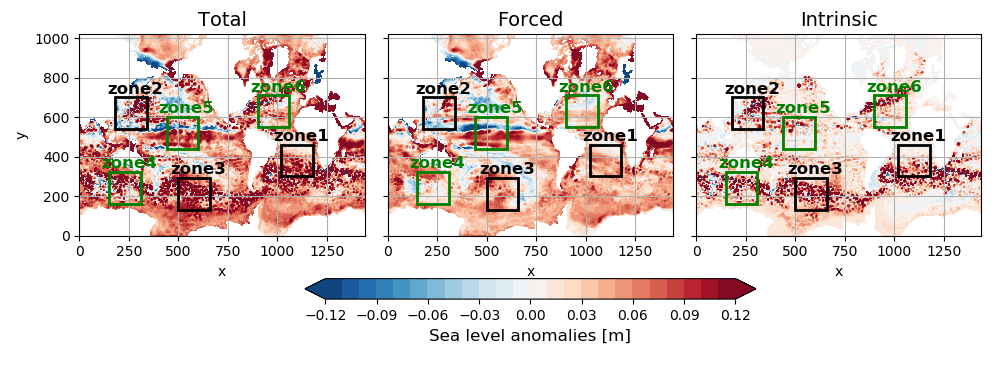

In [6]:
zone_names = ['zone1', 'zone2', 'zone3', 'zone4', 'zone5', 'zone6']

c = concat.plot.contourf(
    col='component', col_wrap=3, figsize=(10,3.8), levels=np.arange(-0.12,0.13,0.01), cmap='RdBu_r',
    zorder=-1, # For rasterazing this layer (otherwise too havy in pdf)
    cbar_kwargs={'orientation': 'horizontal', 'shrink': 0.5}
)

titles = ['Total', 'Forced', 'Intrinsic']
for i, ax in enumerate(c.axes.flat):
    ax.set_rasterization_zorder(0) # Rasterize  all layer < to zorder=0
    ax.set_title(titles[i], size=14)
    ax.grid()
    
    for zone_name in zone_names:
        x_min, x_max, y_min, y_max = u.get_zone(zone_name)

        # Training zones
        if zone_name in ['zone1', 'zone2', 'zone3']:
            color='black'
        # Testing zones
        else:
            color='green'

        rect = Rectangle((x_min,y_min), x_max-x_min, y_max-y_min, 
                         linewidth=2, edgecolor=color, facecolor='none', zorder=10)
        ax.add_patch(rect)
        ax.annotate(zone_name, xy=(x_min-40, y_max+20), fontsize=12, color=color, fontweight='bold')

c.cbar.set_label('Sea level anomalies [m]', size=12)
plt.savefig('img/signals_with_zones.pdf', dpi=300)
plt.savefig('img/signals_with_zones.png', dpi=300)

<IPython.core.display.Javascript object>


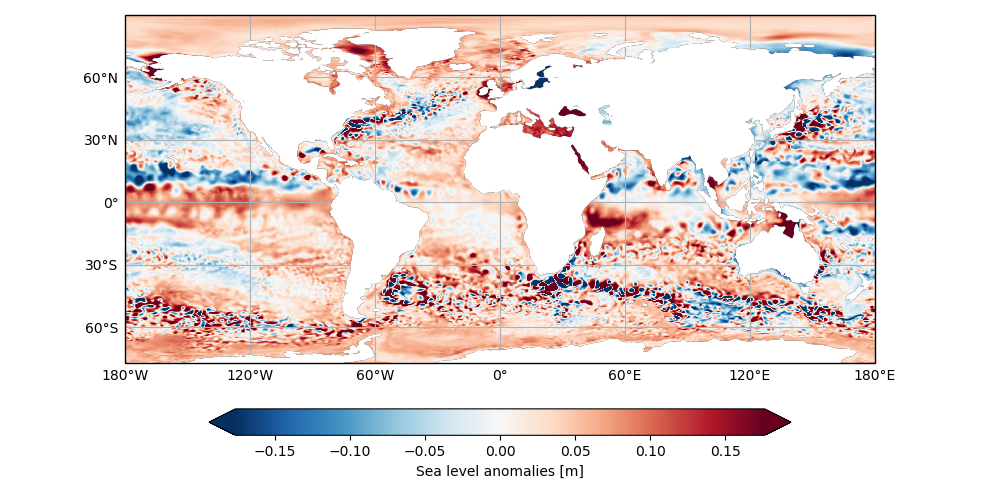

In [7]:
plt.figure(figsize=(10,5))

ax = plt.axes(projection=ccrs.PlateCarree())
cmap = plt.cm.RdBu_r
cmap.set_bad('white', 0)
total.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='nav_lon', y='nav_lat', robust=True, cmap=cmap,
                     cbar_kwargs={'orientation': 'horizontal', 'shrink': 0.6, 'pad': 0.1}, zorder=-1)
ax.set_rasterization_zorder(0)
ax.add_feature(cart.feature.LAND, zorder=2, edgecolor='black', color='white')
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator(range(-180,180+60,60))
gl.ylocator = mticker.FixedLocator(range(-90,90+30,30))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.title('')
plt.tight_layout()
plt.savefig('img/map_platecarree.pdf', dpi=300)
plt.savefig('img/map_platecarree.png', dpi=300)
plt.show()